In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.api import OLS, add_constant
import tensorflow as tf
print("TensorFlow version:", tf.__version__) #Check Tensorflow version is at least 2.8!

TensorFlow version: 2.12.0


In [36]:
#Reading the CSV file merging two data sets
data = pd.read_csv('Fama_French_5_Factors_Daily.csv', 
                   index_col = 'Date', parse_dates = ['Date'])
AAPL = pd.read_csv('AAPL.csv', index_col = 'Date', parse_dates = ['Date'], 
                   usecols = ['Date', 'Price'])

data = pd.concat((data, AAPL), axis = 1)
data['Returns'] = np.log(1. + data['Price'].pct_change()) * 100.
data['ExcessReturns'] = data['Returns'] - data['RF']
data = data.dropna() # Dropping any incomplete rows from the dataset 
data

,ERP,SMB,HML,RMW,CMA,RF,Price,Returns,ExcessReturns
Date,,,,,,,,,
1980-12-15,0.11,0.20,-0.49,0.35,-0.37,0.059,0.384517,-5.358407,-5.417407
1980-12-16,0.71,-0.76,-0.47,0.47,-0.28,0.059,0.356296,-7.622616,-7.681616
1980-12-17,1.52,-0.73,-0.34,0.11,-0.41,0.059,0.365115,2.445053,2.386053
1980-12-18,0.41,0.34,1.27,-1.13,0.27,0.059,0.375698,2.857326,2.798326
1980-12-19,0.58,0.21,0.60,-0.52,0.40,0.059,0.398628,5.924302,5.865302
...,...,...,...,...,...,...,...,...,...
2020-04-24,1.44,0.29,-0.09,-0.14,0.16,0.000,282.206085,2.846075,2.846075
2020-04-27,1.73,2.20,2.74,-0.12,0.20,0.000,282.405548,0.070655,0.070655
2020-04-28,-0.44,1.65,2.89,1.39,0.74,0.000,277.827911,-1.634225,-1.634225


In [37]:
# Segregating the 5 main factors for the model.
factors = ['ERP', 'SMB', 'HML', 'RMW', 'CMA']
#Training and testing the dataset  
train_data = data.loc[:'2019-04-30'].copy()
test_data = data.loc['2019-04-30':].copy()
data[factors]

,ERP,SMB,HML,RMW,CMA
Date,,,,,
1980-12-15,0.11,0.20,-0.49,0.35,-0.37
1980-12-16,0.71,-0.76,-0.47,0.47,-0.28
1980-12-17,1.52,-0.73,-0.34,0.11,-0.41
1980-12-18,0.41,0.34,1.27,-1.13,0.27
1980-12-19,0.58,0.21,0.60,-0.52,0.40
...,...,...,...,...,...
2020-04-24,1.44,0.29,-0.09,-0.14,0.16
2020-04-27,1.73,2.20,2.74,-0.12,0.20
2020-04-28,-0.44,1.65,2.89,1.39,0.74


In [38]:
# Linear regression model 
lin_reg = add_constant(train_data[factors])
lin_model = OLS(train_data['ExcessReturns'], lin_reg).fit()
# Summary of the regression model 
print(lin_model.summary())

                            OLS Regression Results                            
Dep. Variable:          ExcessReturns   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     673.7
Date:                Sat, 08 Apr 2023   Prob (F-statistic):               0.00
Time:                        17:53:55   Log-Likelihood:                -22674.
No. Observations:                9675   AIC:                         4.536e+04
Df Residuals:                    9669   BIC:                         4.540e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0371      0.026      1.444      0.1

In [39]:
# Testing the regression model 
test_reg = add_constant(test_data[factors])
p_excess = lin_model.predict(test_reg)

# Adding a new colomn "FamaFrencPredictions" to the test dataset
test_data['FamaFrenchPredictions'] = p_excess + test_data['RF']
test_data

,ERP,SMB,HML,RMW,CMA,RF,Price,Returns,ExcessReturns,FamaFrenchPredictions
Date,,,,,,,,,,
2019-04-30,-0.04,-0.67,0.25,0.09,0.70,0.010,197.542618,-1.944398,-1.954398,-0.787903
2019-05-01,-0.83,-0.08,-0.06,0.37,-0.03,0.009,207.239120,4.791895,4.782895,-0.846855
2019-05-02,-0.16,0.48,-0.49,0.08,0.06,0.009,205.890457,-0.652903,-0.661903,-0.004328
2019-05-03,1.13,0.94,-0.27,0.01,-0.36,0.009,208.449951,1.235470,1.226470,1.689720
2019-05-06,-0.39,0.59,-0.45,0.01,0.05,0.009,205.230911,-1.556323,-1.565323,-0.262591
...,...,...,...,...,...,...,...,...,...,...
2020-04-24,1.44,0.29,-0.09,-0.14,0.16,0.000,282.206085,2.846075,2.846075,1.479744
2020-04-27,1.73,2.20,2.74,-0.12,0.20,0.000,282.405548,0.070655,0.070655,0.198864
2020-04-28,-0.44,1.65,2.89,1.39,0.74,0.000,277.827911,-1.634225,-1.634225,-2.971378


In [40]:
# Preparing the data for a machine learning model by converting it into the format that TensorFlow expects. 
# Once the data is in tensor form, it can be fed into a TensorFlow model and used to train and evaluate the model.
x_train = tf.convert_to_tensor(train_data[factors])
x_test = tf.convert_to_tensor(test_data[factors])
y_train = tf.convert_to_tensor(train_data['ExcessReturns'])
y_test = tf.convert_to_tensor(test_data['ExcessReturns'])

In [41]:
#the neural network model has two hidden layers, each followed by a dropout layer, and a single output layer. 
#The L1 regularization is used to help prevent overfitting of the model to the training data.
nnet_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation = 'relu', 
                          kernel_regularizer = tf.keras.regularizers.L1(.001), 
                          bias_regularizer = tf.keras.regularizers.L1(.001)),
    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(32, activation = 'relu', 
                          kernel_regularizer = tf.keras.regularizers.L1(.001), 
                          bias_regularizer = tf.keras.regularizers.L1(.001)),
    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(1),
])

In [43]:
# Setting up the neural network model to use the Adam optimizer with a learning rate of 0.00005 and the mean squared error loss function
loss = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate = .00005)

nnet_model.compile(optimizer = opt, loss = loss)

In [44]:
# Training the compiled neural network model (nnet_model) on the training data (x_train and y_train), 
# using the fit method provided by the TensorFlow Keras API
history = nnet_model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 200, shuffle = True, batch_size = 200)

Epoch 1/200
49/49 [==============================] - 1s 3ms/step - loss: 8.3000 - val_loss: 6.1061
Epoch 2/200
49/49 [==============================] - 0s 1ms/step - loss: 8.2669 - val_loss: 5.9647
Epoch 3/200
49/49 [==============================] - 0s 1ms/step - loss: 8.1811 - val_loss: 5.8301
Epoch 4/200
49/49 [==============================] - 0s 1ms/step - loss: 8.1299 - val_loss: 5.6925
Epoch 5/200
49/49 [==============================] - 0s 1ms/step - loss: 8.0566 - val_loss: 5.5590
Epoch 6/200
49/49 [==============================] - 0s 1ms/step - loss: 8.0101 - val_loss: 5.4261
Epoch 7/200
49/49 [==============================] - 0s 1ms/step - loss: 7.9585 - val_loss: 5.2930
Epoch 8/200
49/49 [==============================] - 0s 1ms/step - loss: 7.9057 - val_loss: 5.1651
Epoch 9/200
49/49 [==============================] - 0s 1ms/step - loss: 7.8511 - val_loss: 5.0401
Epoch 10/200
49/49 [==============================] - 0s 1ms/step - loss: 7.8055 - val_loss: 4.9095
Epoch 11/

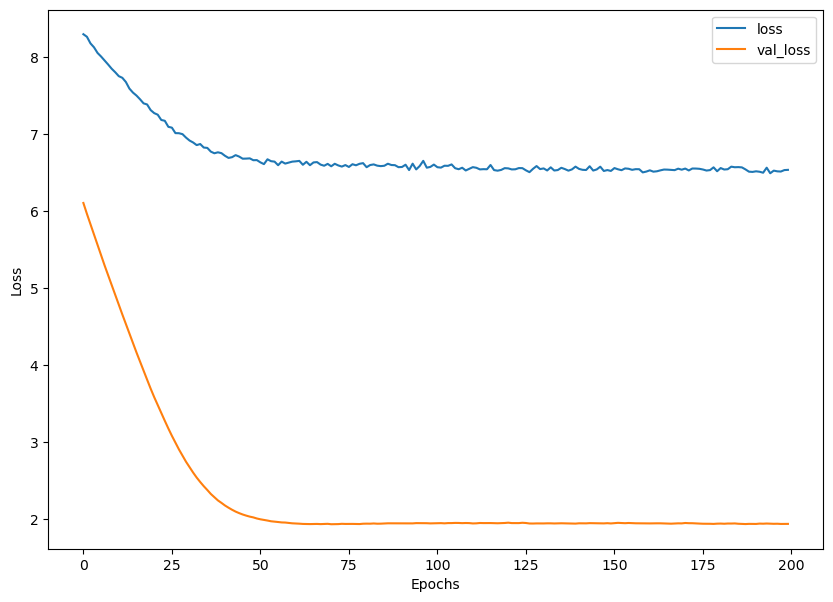

In [45]:
# Created a plot to compare the training and validation loss over the epochs of the trained model
plt.figure(figsize = (10, 7))
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [46]:
# Using a neural network to make predictions on some test data, and then adding those predictions to another column in a DataFrame.
nnet_pred = nnet_model(X_test).numpy()
test_data['NeuralNetPredictions'] = nnet_pred.squeeze() + test_data['RF']

test_data

,ERP,SMB,HML,RMW,CMA,RF,Price,Returns,ExcessReturns,FamaFrenchPredictions,NeuralNetPredictions
Date,,,,,,,,,,,
2019-04-30,-0.04,-0.67,0.25,0.09,0.70,0.010,197.542618,-1.944398,-1.954398,-0.787903,-0.722821
2019-05-01,-0.83,-0.08,-0.06,0.37,-0.03,0.009,207.239120,4.791895,4.782895,-0.846855,-0.999818
2019-05-02,-0.16,0.48,-0.49,0.08,0.06,0.009,205.890457,-0.652903,-0.661903,-0.004328,0.009662
2019-05-03,1.13,0.94,-0.27,0.01,-0.36,0.009,208.449951,1.235470,1.226470,1.689720,1.697308
2019-05-06,-0.39,0.59,-0.45,0.01,0.05,0.009,205.230911,-1.556323,-1.565323,-0.262591,-0.154999
...,...,...,...,...,...,...,...,...,...,...,...
2020-04-24,1.44,0.29,-0.09,-0.14,0.16,0.000,282.206085,2.846075,2.846075,1.479744,1.628045
2020-04-27,1.73,2.20,2.74,-0.12,0.20,0.000,282.405548,0.070655,0.070655,0.198864,-0.151818
2020-04-28,-0.44,1.65,2.89,1.39,0.74,0.000,277.827911,-1.634225,-1.634225,-2.971378,-3.105306


In [47]:
# Predicting the price of the stock using the Fama French 5 factor model & calculating the change in price of the stock.
linear_price = test_data.loc['2019-04-30', 'Price'] * np.exp(np.cumsum(test_data['FamaFrenchPredictions'] / 100.))

In [48]:
# Predicting the price of the stock using the neural network & calculating the change in price of the stock.
nnet_price = test_data.loc['2019-04-30', 'Price'] * np.exp(np.cumsum(test_data['NeuralNetPredictions'] / 100.))

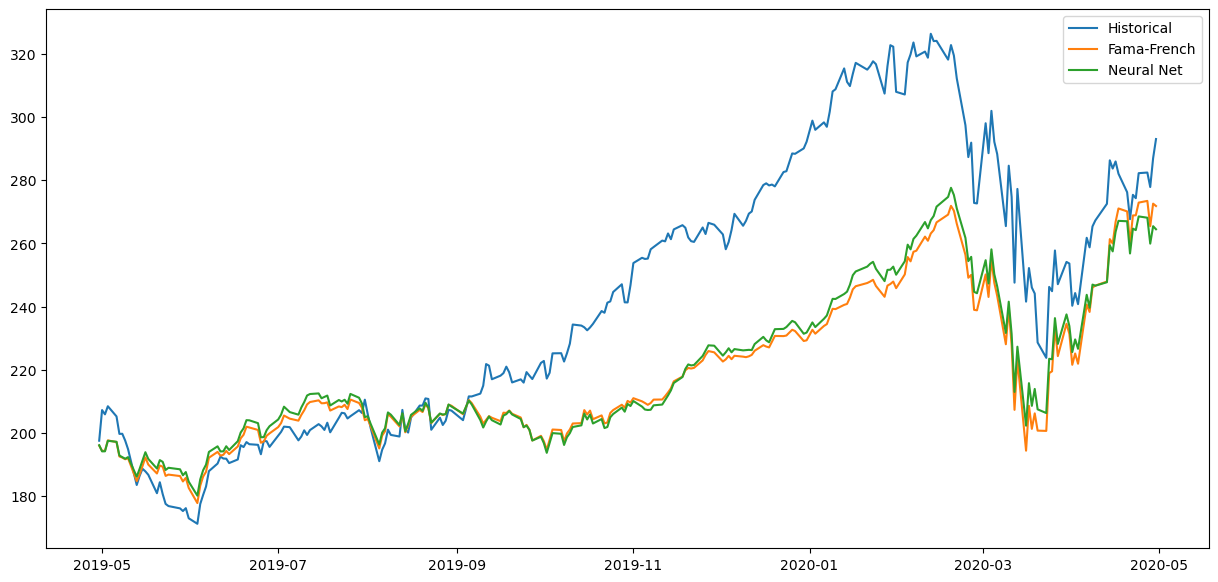

In [49]:
#Plotting the test_data to show and compare the historical data with the predictions from the linear regression model and the neural network.
plt.figure(figsize = (15,7))
plt.plot(test_data['Price'], label = 'Historical')
plt.plot(linear_price, label = 'Fama-French')
plt.plot(nnet_price, label = 'Neural Net')
plt.legend()
plt.show()